In [162]:
%%capture
%run preprocessing.ipynb

In [163]:
# Affiche les variables et modules importés depuis le notebook preprocessing.ipynb
%whos

Variable                Type         Data/Info
----------------------------------------------
Counter                 type         <class 'collections.Counter'>
KMeans                  ABCMeta      <class 'sklearn.cluster._kmeans.KMeans'>
KneeLocator             type         <class 'kneed.knee_locator.KneeLocator'>
MiniBatchKMeans         ABCMeta      <class 'sklearn.cluster._kmeans.MiniBatchKMeans'>
PCA                     ABCMeta      <class 'sklearn.decomposition._pca.PCA'>
TSNE                    type         <class 'sklearn.manifold._t_sne.TSNE'>
X                       ndarray      1352205x128: 173082240 elems, type `float32`, 692328960 bytes (660.25634765625 Mb)
X_tsne                  ndarray      1050x2: 2100 elems, type `float32`, 8400 bytes
adjusted_rand_score     function     <function adjusted_rand_s<...>re at 0x0000019F8888EF20>
analyse_images          function     <function analyse_images at 0x0000019FF27DF9C0>
ari                     tuple        n=3
ari_scores         

In [164]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
from collections import Counter
import cv2

from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [165]:
image_df = globals()['flipkart']
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.7+ KB
None


# Analyse exploratoire sur les images

Lors de l'analyse pré-exploratoire, on a gardé la colonne `image` qui contient les noms de fichiers avec extension.<br>
Regardons l'analyse sur la taille des images présentes dans le dataset.

In [166]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

In [167]:
def extract_img_features(image_names_list, path):
    img_height = []
    img_width = []
    img_channels = []
    img_size = []

    for img in image_names_list:
        image = cv2.imread(path + img)
        img_height.append(image.shape[0])
        img_width.append(image.shape[1])
        img_channels.append(image.shape[2])
        img_size.append(image.size)

    return pd.DataFrame({'height': img_height, 'width': img_width, 'channels': img_channels, 'size': img_size})
    del(image, img_height, img_width, img_channels, img_size)
    gc.collect()

In [168]:
image_df = pd.concat([image_df, extract_img_features(image_df['image'], path)], axis=1)
print(image_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   image     1050 non-null   object  
 1   class     1050 non-null   category
 2   height    1050 non-null   int64   
 3   width     1050 non-null   int64   
 4   channels  1050 non-null   int64   
 5   size      1050 non-null   int64   
dtypes: category(1), int64(4), object(1)
memory usage: 42.5+ KB
None


In [169]:
# Aperçu des statistiques descriptives des features extraites
print(image_df.select_dtypes(include='int').describe())

             height        width  channels          size
count   1050.000000  1050.000000    1050.0  1.050000e+03
mean    1220.038095  1196.570476       3.0  5.748901e+06
std      744.841368   864.076765       0.0  1.175770e+07
min      160.000000   145.000000       3.0  1.740000e+05
25%      844.000000   747.250000       3.0  2.017125e+06
50%     1100.000000  1100.000000       3.0  3.047550e+06
75%     1360.000000  1214.250000       3.0  4.661820e+06
max    11042.000000  8484.000000       3.0  2.810410e+08


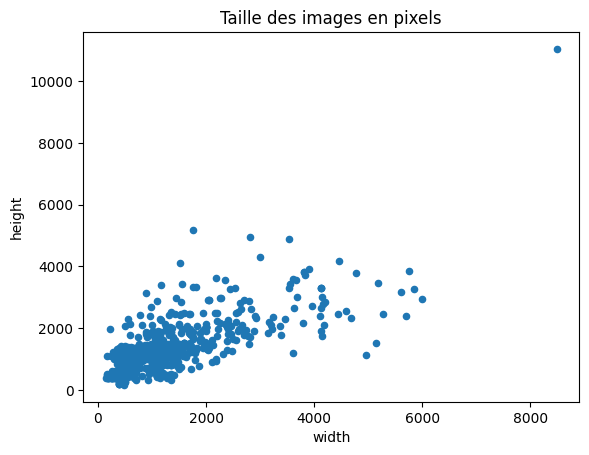

In [170]:
# Scatter plot de la taille des images
image_df.filter(["height", "width"]).plot(kind='scatter', x='width', y='height')
plt.title("Taille des images en pixels")
plt.show()

On constate qu'il y a tout type de taille d'image dont un outlier avec une taille extrêmement grande.<br>
Dans le cas des descripteurs SIFT, il est préférable de redimensionner les images avec un palier de dimension maximum pour améliorer la qualité et la rapidité de calcul.


Je conserve la liste des labels uniques sous une variable pour faciliter les traitements ultérieurs:

In [171]:
# Récupère les labels uniques dans une liste
list_labels = list(image_df['class'].unique())
print(list_labels)

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


# CNN

Test des différents modèles de CNN pour l'étude de faisabilité

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

from tensorflow.keras.applications.vgg16 import decode_predictions as vgg16_decode_predictions
from tensorflow.keras.applications.resnet50 import decode_predictions as resnet50_decode_predictions
from tensorflow.keras.applications.inception_v3 import decode_predictions as inception_v3_decode_predictions
from tensorflow.keras.applications.efficientnet import decode_predictions as efficientnet_decode_predictions

In [ ]:
def compile_model():
    model = VGG16()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [82]:
def ARI_cnn(images, n_clusters=7):
    # Crée un data generator pour les images
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Crée le data generator
    datagenerator = datagen.flow(
        images,
        batch_size=32,
        shuffle=False  # Ne pas mélanger les images pour pouvoir les retrouver plus tard lors du calcul de l'adjusted rand score
    )
    # Crée les embeddings
    embeddings = embedding_model.predict(datagenerator)
    # Affiche la taile des embeddings
    print('Raw shape: ', embeddings.shape)
    embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
    print('Flat shape: ', embeddings_flat.shape)

    # Réduction de la dimensionnalité des embeddings
    pca = PCA(n_components=0.95)

    # Fit et transforme les embeddings
    embeddings_pca = pca.fit_transform(embeddings_flat)
    # Affiche la taille des embeddings après PCA
    print('PCA shape: ', embeddings_pca.shape)

    # Crée le modèle KMeans
    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings_pca)

    ari = adjusted_rand_score(flipkart_filtered['category_0'], clusters)
    print(f"Adjusted Rand Index: {ari}")
    return ari

In [37]:
ari_scores = []

### EFFICIENT NET CLASSIFICATION

Le modèle EfficientNetB0 est un modèle de convolution pré-entraîné sur ImageNet qui est capable de classifier des images en 1000 catégories.<br>
Nous allons retirer la dernière couche du modèle et recréer une nouvelle couche de classification avec 7 classes qui correspondent aux catégories de produits.<br>


Commençons par charger le modèle EfficientNetB0 pré-entraîné sur ImageNet et retirer la dernière couche de classification:

In [9]:
# Charge le modèle sous la variable efficient_model
efficient_model = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
    )

In [11]:
%%capture
# Affiche l'architecture du modèle
efficient_model.summary()

Le modèle est composé d'un grand nombre de couche de convolution et de normalisation qui permettent d'extraire des features de plus en plus abstraites des images.<br>
Nous allons ajouter une couche de classification avec 7 neurones qui correspondent aux catégories de produits.

In [9]:
# On récupère l'output du modèle
x = efficient_model.output

In [10]:
# Ajout d'une couche de pooling suivant d'une couche FC puis d'une couche de classification à 7 classes
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)

In [11]:
# Création du modèle à jour avec les couches d'entrée d'efficient et les couches de sortie ajoutées
updated_model = Model(inputs=efficient_model.input, outputs=x)

In [12]:
# Paramètre les couches de l'input à trainable=False
for layer in efficient_model.layers:
    layer.trainable = False

In [13]:
# Compile le modèle
updated_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

A présent, pour entraîner notre modèle, nous allons devoir préparer nos données d'image pour les envoyer dans le modèle.<br>

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
train_datagen_wh = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    flipkart_filtered,
    directory=path,
    x_col='image',
    y_col='category_0',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 1050 validated image filenames belonging to 7 classes.


In [16]:
updated_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10
)

Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.1555 - loss: 1.9865

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 22/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.1515 - loss: 1.9810

KeyboardInterrupt: 

Les dimensions HxLxC du tenseur d'entrée sont 224x224x3.<br>
Je dois adapter toutes les images à ces dimensions pour pouvoir les envoyer dans le modèle CNN:

In [ ]:
# Création d'une liste qui contient toutes les images redimensionnées sous forme de batch



### EFFICIENT NET EMBEDDINGS

In [43]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [44]:
# Définition de la taille des images
size = (224, 224)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 7, 7, 1280)

In [45]:
%%capture
eff_model.summary()

In [46]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [47]:
for image in tqdm([opencv_224, tf_224, custom_224]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step 
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 33%|███▎      | 1/3 [01:16<02:32, 76.11s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.32339832231164917


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 67%|██████▋   | 2/3 [02:05<01:00, 60.46s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.3244894274108034


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


100%|██████████| 3/3 [03:00<00:00, 60.28s/it]

PCA shape:  (1050, 623)
Adjusted Rand Index: 0.17948141823801084


In [48]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084]


In [77]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 11, 11, 1280)

In [78]:
%%capture
eff_model.summary()

In [79]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [83]:
ARI_cnn(opencv_336, preprocessing=False)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)
PCA shape:  (1050, 743)
Adjusted Rand Index: 0.3556772032685982


0.3556772032685982

In [53]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084, 0.3556772032685982, 0.3556772032685982, 0.15248888772357608]


In [ ]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 11, 11, 1280)

In [ ]:
%%capture
eff_model.summary()

In [ ]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [ ]:
for image in tqdm([opencv_336, tf_336, custom_336]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)
PCA shape:  (1050, 743)


 33%|███▎      | 1/3 [02:18<04:36, 138.43s/it]

Adjusted Rand Index: 0.3556772032685982


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)


 67%|██████▋   | 2/3 [04:20<02:08, 128.72s/it]

PCA shape:  (1050, 743)
Adjusted Rand Index: 0.3556772032685982


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)


100%|██████████| 3/3 [06:15<00:00, 125.20s/it]

PCA shape:  (1050, 704)
Adjusted Rand Index: 0.15248888772357608


In [ ]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084, 0.3556772032685982, 0.3556772032685982, 0.15248888772357608]


### VGG16 EMBEDDINGS

In [96]:
ari_scores = []

In [97]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [98]:
# Définition de la taille des images
size = (224, 224)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle vgg16
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
vgg16_model.output.shape

(None, 7, 7, 512)

In [99]:
%%capture
vgg16_model.summary()

In [100]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(vgg16_model.input, last_conv_layer.output)

In [102]:
ARI_cnn(opencv_224, preprocessing=False)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step
Raw shape:  (1050, 14, 14, 512)
Flat shape:  (1050, 100352)
PCA shape:  (1050, 777)
Adjusted Rand Index: 0.12095135314160917


0.12095135314160917

In [95]:
for image in tqdm([opencv_224, tf_224, custom_224]):
    ari_scores.append(ARI_cnn(image, preprocessing=False))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4:02 8s/step

  0%|          | 0/3 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(ari_scores)

In [ ]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
# Création du modèle vgg16
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
vgg16_model.output.shape

(None, 11, 11, 1280)

In [ ]:
%%capture
vgg16_model.summary()

In [ ]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(vgg16_model.input, last_conv_layer.output)

In [ ]:
for image in tqdm([opencv_336, tf_336, custom_336]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step 
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)
PCA shape:  (1050, 666)


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
 33%|███▎      | 1/3 [01:13<02:27, 73.52s/it]

Adjusted Rand Index: 0.32339832231164917


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 893ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 67%|██████▋   | 2/3 [02:24<01:11, 71.75s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.3244894274108034


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 719ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


100%|██████████| 3/3 [03:10<00:00, 63.63s/it]

PCA shape:  (1050, 623)
Adjusted Rand Index: 0.17948141823801084


In [ ]:
print(ari_scores)

### VGG16 CLASSIFICATION

In [8]:
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [9]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_classes = flipkart_filtered['category_0'].nunique()

In [ ]:
x = vgg16_model.output

# Ajoute une couche de classification à 7 classes
x = Dense(n_classes, activation='softmax')(x)

In [ ]:
# Crée le modèle
vgg16 = Model(inputs=vgg16_model.input, outputs=x)

# Paramètre les couches de l'input à trainable=False pour ne pas réentraîner les poids et faire de l'extraction features
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
# Compile le modèle
vgg16.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# VISUAL BAG OF WORDS

On va tester différents paramètres pour évaluer si les descripteurs SIFT nous permettent de distinguer de manière non supervisée les images.<br>
Suite à l'analyse des images, on va considérer les paramètres suivants à tester :
* Redimensionnement des images en 600x600 et 300x300 maximum (2)
    * Déterminer une sélection de 3 clusters à retenir évaluer l'ARI (3)
        * Compression PCA à 0.95 (1)


**Soit un total de 6 combinaisons à tester.**

In [173]:
ari_scores = list()

## Définition des fonctions utilisés pour tester les diffèrentes combinaisons de paramètres

In [174]:
def extract_descriptors(df, path, max_height=600, max_width=600):
    sift_descriptors = []
    for row in tqdm(df.itertuples()):
        if row.height > max_height or row.width > max_width:
            height, width = row.height, row.width
            max_value = max(height, width)
            ratio = 600 / max_value
            new_height = int(height * ratio)
            new_width = int(width * ratio)
            image = cv2.imread(path + row.image, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (new_height, new_width), interpolation=cv2.INTER_AREA)
        else:
            image = cv2.imread(path + row.image, cv2.IMREAD_GRAYSCALE)
        image = cv2.equalizeHist(image)
        sift = cv2.SIFT_create()
        _, descriptors = sift.detectAndCompute(image, None)
        sift_descriptors.append(descriptors)
    return sift_descriptors
    del(height, width, max_value, ratio, new_height, new_width, image, sift, descriptors)
    gc.collect()
    


In [175]:
# Fonction pour déterminer un range de cluster à tester pour déterminer le nombre optimal de Visual Words
def cluster_range(X, list_labels, n=10):    
    # Détermination du nombre de clusters avec la racine carrée du nombre de descriptors
    n_clusters_sqrt = int(np.sqrt(len(X)))
    print("Nombre de clusters - méthode racine carrée : ", n_clusters_sqrt)

    # Détermination du nombre de clusters par multiplier par 10 le nombre de labels existants
    n_clusters_ten = len(list_labels) * 10
    print("Nombre de clusters - méthode nbre_labels * 10 : ", n_clusters_ten)

    # Créatio d'une liste de n clusters à tester
    rng_clusters = np.linspace(n_clusters_ten, n_clusters_sqrt, n).astype(int)
    print("Longueur de la liste de clusters à tester: ", len(rng_clusters))

    return rng_clusters

In [176]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def return_inertia_labels(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    return inertia, labels

In [177]:
def plot_optimalk(X, rng_clusters):    
    # Tester plusieurs valeurs de clusters pour trouver le meilleur
    inertia_list = []
    labels_list = []
    for n_clusters in tqdm(rng_clusters):
        inertia, labels = return_inertia_labels(X, n_clusters)
        inertia_list.append(inertia)
        labels_list.append(labels)
    
    # Détermine le optimal-K avec la méthode du coude
    optimal_k = KneeLocator(rng_clusters, inertia_list, curve='convex', direction='decreasing').elbow

    # Affiche la courbe d'inertie en fonction du nombre de clusters
    plt.figure(figsize=(12, 6))
    plt.plot(rng_clusters, inertia_list, marker='o')
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title('Inertie en fonction du nombre de clusters')
    plt.legend()
    plt.grid()
    plt.show()

In [178]:
def build_histogram(descriptors, kmeans, n_labels):
    labels = kmeans.predict(descriptors)
    hist = Counter(labels)
    return hist, len(descriptors)

In [179]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def return_model(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans

In [180]:
def return_hist_vector(X, n_cluster, sift_descriptors):
    kmeans = return_model(X, n_cluster)
    hist_vector = []
    for descriptors in tqdm(sift_descriptors):
        hist, n_descriptor = build_histogram(descriptors, kmeans, n_cluster)
        counter = dict(sorted(hist.items()))
        vector = np.array([counter.get(i) if i in counter.keys() else 0 for i in range(n_cluster)])/n_descriptor
        hist_vector.append(vector)
    return np.array(hist_vector)

## Test des combinaisons de paramètres

1050it [01:32, 11.33it/s]


Points d'intérêts / descripteurs image :  (1379700, 128)
Nombre de clusters - méthode racine carrée :  1174
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  10


100%|██████████| 10/10 [04:23<00:00, 26.33s/it]


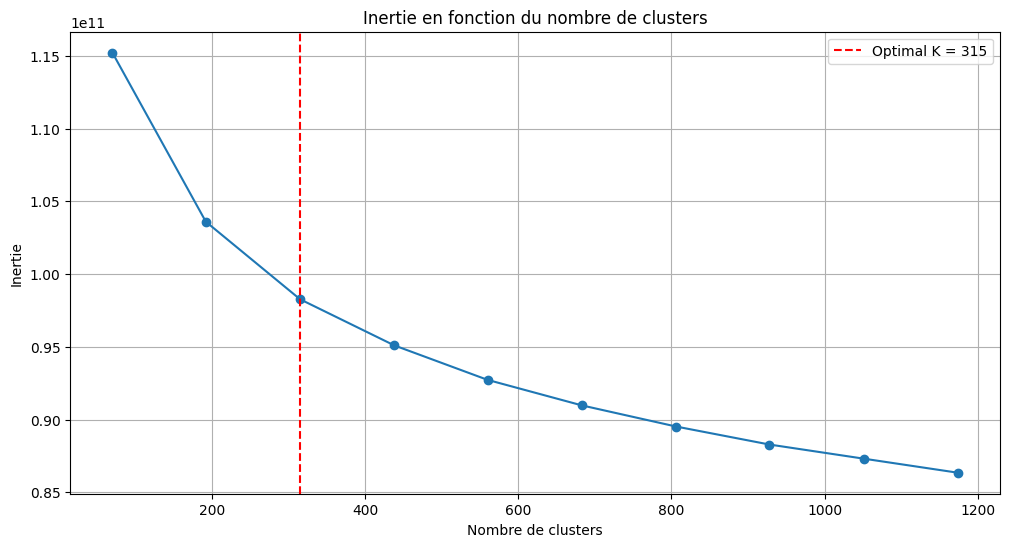

In [181]:
# Défintion des paramètres à tester
resize = 300
sift_descriptors_300 = extract_descriptors(image_df, path, max_height=resize, max_width=resize)

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors_300, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels)

# Affiche la courbe d'inertie en fonction du nombre de clusters
plot_optimalk(X, rng_clusters)

In [182]:
# Définit la liste des clusters à tester
clusters = [315, 800, 1170]

# Définition pour le taux de réduction de la pca
pca_threshold = 0.95

# Itère sur les clusters à tester
for cluster in tqdm(clusters):
    hist_vector = return_hist_vector(X, cluster, sift_descriptors_300)
    pca = PCA(n_components=pca_threshold)
    pca_vector = pca.fit_transform(hist_vector)
    kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
    kmeans.fit(pca_vector)
    ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
    ari_scores.append((resize, cluster, ari))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -   n_clusters: {ari[1]}    -    ARI: {ari[2]}")

100%|██████████| 3/3 [02:03<00:00, 41.31s/it]

max_size: 300    -   n_clusters: 315    -    ARI: 0.05931027124417893
max_size: 300    -   n_clusters: 800    -    ARI: 0.056292944514665925
max_size: 300    -   n_clusters: 1170    -    ARI: 0.030988836426962114


1050it [01:32, 11.32it/s]


Points d'intérêts / descripteurs image :  (1352205, 128)
Nombre de clusters - méthode racine carrée :  1162
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  10


100%|██████████| 10/10 [04:45<00:00, 28.58s/it]


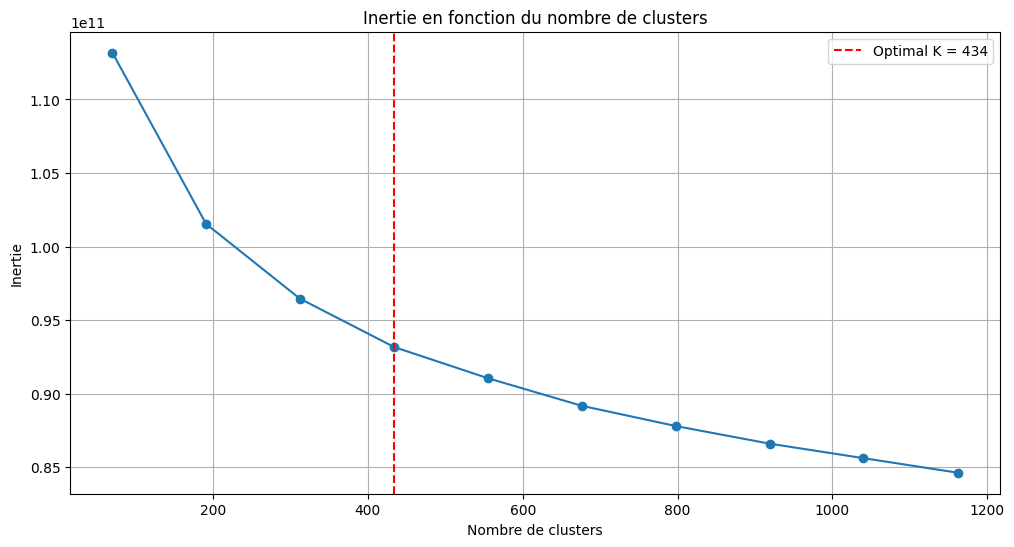

In [183]:
# Défintion des paramètres à tester
resize = 600
sift_descriptors_600 = extract_descriptors(image_df, path, max_height=resize, max_width=resize)

# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors_600, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X, list_labels)

# Affiche la courbe d'inertie en fonction du nombre de clusters
plot_optimalk(X, rng_clusters)

In [184]:
# Définit la liste des clusters à tester
clusters = [434, 800, 1170]

# Définition pour le taux de réduction de la pca
pca_threshold = 0.95

# Itère sur les clusters à tester
for cluster in tqdm(clusters):
    hist_vector = return_hist_vector(X, cluster, sift_descriptors_600)
    pca = PCA(n_components=pca_threshold)
    pca_vector = pca.fit_transform(hist_vector)
    kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
    kmeans.fit(pca_vector)
    ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
    ari_scores.append((resize, cluster, ari))

# Affichage des résultats
for ari in ari_scores:
    print(f"max_size: {ari[0]}    -   n_clusters: {ari[1]}    -    ARI: {ari[2]}")

100%|██████████| 3/3 [03:25<00:00, 68.47s/it]

max_size: 300    -   n_clusters: 315    -    ARI: 0.05931027124417893
max_size: 300    -   n_clusters: 800    -    ARI: 0.056292944514665925
max_size: 300    -   n_clusters: 1170    -    ARI: 0.030988836426962114
max_size: 600    -   n_clusters: 434    -    ARI: 0.05950829435702206
max_size: 600    -   n_clusters: 800    -    ARI: 0.04009851695976828
max_size: 600    -   n_clusters: 1170    -    ARI: 0.04433520593981941


## VISUALISATION DES RESULTATS

In [185]:
del(sift_descriptors_600, X, ari_scores, ari, clusters, rng_clusters)
gc.collect()

15

In [189]:
params = (sift_descriptors_300, 0.95, 7, 315)
X = np.concatenate(params[0], axis=0)

# Paramètres pour T-SNE
tsne = TSNE(n_components=2, perplexity=30, 
                     max_iter=2000, init='random', random_state=42)

hist_vector = return_hist_vector(X, params[3], params[0])
pca = PCA(n_components=params[1])
pca_vector = pca.fit_transform(hist_vector)
kmeans = KMeans(n_clusters=params[2], random_state=42)
kmeans.fit(pca_vector)
X_tsne = tsne.fit_transform(pca_vector)
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_df['class']
df_tsne["labels"] = kmeans.labels_
df_tsne['class'] = df_tsne['class'].astype('category')

100%|██████████| 1050/1050 [00:11<00:00, 88.87it/s]


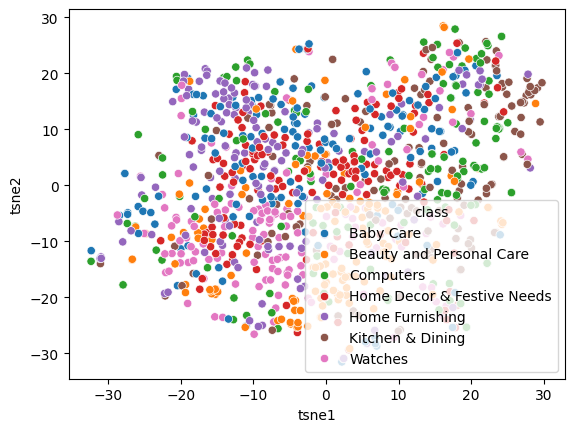

In [190]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='class')
plt.show()

<Axes: xlabel='tsne1', ylabel='tsne2'>

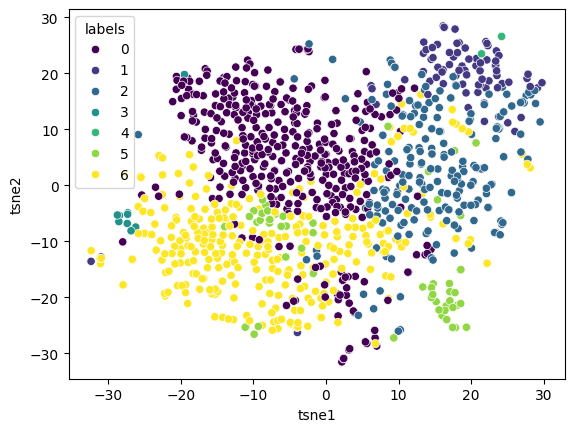

In [192]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='labels', palette='viridis')